In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'

In [3]:
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36',
    'accept-encoding': 'gzip, deflate, br' ,
    'accept-language': 'en-US,en;q=0.9'
    
}

In [4]:
session = requests.Session()
request = session.get(url, headers=headers)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, cookies=cookies).json()
rawdata = pd.DataFrame(response)

In [5]:
raw_op = pd.DataFrame(rawdata["filtered"]["data"]).fillna(0)

In [6]:
raw_op

,strikePrice,expiryDate,CE,PE
0,15100,03-Feb-2022,"{'strikePrice': 15100, 'expiryDate': '03-Feb-2...","{'strikePrice': 15100, 'expiryDate': '03-Feb-2..."
1,15150,03-Feb-2022,"{'strikePrice': 15150, 'expiryDate': '03-Feb-2...","{'strikePrice': 15150, 'expiryDate': '03-Feb-2..."
2,15200,03-Feb-2022,"{'strikePrice': 15200, 'expiryDate': '03-Feb-2...","{'strikePrice': 15200, 'expiryDate': '03-Feb-2..."
3,15250,03-Feb-2022,"{'strikePrice': 15250, 'expiryDate': '03-Feb-2...","{'strikePrice': 15250, 'expiryDate': '03-Feb-2..."
4,15300,03-Feb-2022,"{'strikePrice': 15300, 'expiryDate': '03-Feb-2...","{'strikePrice': 15300, 'expiryDate': '03-Feb-2..."
...,...,...,...,...
90,19600,03-Feb-2022,"{'strikePrice': 19600, 'expiryDate': '03-Feb-2...","{'strikePrice': 19600, 'expiryDate': '03-Feb-2..."
91,19650,03-Feb-2022,"{'strikePrice': 19650, 'expiryDate': '03-Feb-2...","{'strikePrice': 19650, 'expiryDate': '03-Feb-2..."
92,19700,03-Feb-2022,"{'strikePrice': 19700, 'expiryDate': '03-Feb-2...","{'strikePrice': 19700, 'expiryDate': '03-Feb-2..."
93,19750,03-Feb-2022,"{'strikePrice': 19750, 'expiryDate': '03-Feb-2...","{'strikePrice': 19750, 'expiryDate': '03-Feb-2..."


In [7]:
def dataframe(raw):
    data = []
    for i in range(len(raw)):
        call_oi = call_coi = put_oi = put_coi = call_ltp = put_ltp = 0
        call_IV = put_IV = 0
        strike = raw["strikePrice"][i]
        if(raw["CE"][i]==0):
            calloi = call_coi = 0
        else:
            call_oi = raw["CE"][i]["openInterest"]
            call_coi = raw["CE"][i]["changeinOpenInterest"]
            call_ltp = raw["CE"][i]['lastPrice']
            call_IV = raw["CE"][i]['impliedVolatility']
        
        if(raw["PE"][i]==0):
            putoi = put_coi = 0
        else:
            put_oi = raw["PE"][i]["openInterest"]
            put_coi = raw["PE"][i]["changeinOpenInterest"]
            put_ltp = raw["PE"][i]['lastPrice']
            put_IV = raw["PE"][i]['impliedVolatility']
            
        option_data = {
            "Call OI" : call_oi, "Call C_OI" : call_coi,"Call IV": call_IV ,"Call LTP" : call_ltp, "STRIKE" : strike,
             "Put LTP" : put_ltp ,"Put IV" : put_IV , "Put C_OI" : put_coi, "Put OI" : put_oi
        }
        data.append(option_data)
    optionchain = pd.DataFrame(data)
    return optionchain, raw.iloc[0,2]["underlyingValue"]

In [20]:
optionchain, underlying_ltp = dataframe(raw_op)

In [9]:
underlying_ltp

17101.95

In [10]:
optionchain

,Call OI,Call C_OI,Call IV,Call LTP,STRIKE,Put LTP,Put IV,Put C_OI,Put OI
0,14,13,102.59,2216.60,15100,2.75,41.92,9824,59036
1,0,0,0.00,0.00,15150,3.05,41.49,246,246
2,0,0,0.00,0.00,15200,3.00,40.43,4689,10034
3,0,0,0.00,0.00,15250,3.30,39.94,346,346
4,0,0,0.00,0.00,15300,3.45,39.19,6803,14499
...,...,...,...,...,...,...,...,...,...
90,5169,2403,41.45,1.75,19600,0.00,0.00,0,1
91,189,21,42.01,1.70,19650,0.00,0.00,0,0
92,5251,855,42.55,1.65,19700,0.00,0.00,0,1
93,1538,372,43.23,1.65,19750,0.00,0.00,0,2


In [21]:
option = optionchain.drop(optionchain[(optionchain["Call OI"]<=1000) | (optionchain["Put OI"]<=1000)].index)

In [22]:
option

,Call OI,Call C_OI,Call IV,Call LTP,STRIKE,Put LTP,Put IV,Put C_OI,Put OI
18,1517,-392,77.00,1364.65,16000,9.60,29.96,11243,39842
25,1278,-5,63.93,1021.70,16350,19.90,25.81,1128,2152
28,1833,208,58.84,880.70,16500,29.00,24.26,16980,45729
34,1584,-26,49.89,616.75,16800,64.00,21.20,15571,26078
36,4870,-8405,47.03,533.65,16900,83.90,20.17,1052,19307
37,1022,-576,45.82,495.00,16950,96.05,19.67,414,2334
38,17928,-10238,45.09,461.20,17000,109.00,19.07,20,31488
39,1514,-579,44.00,425.20,17050,123.25,18.34,634,2677
40,20114,5166,43.16,392.40,17100,138.80,17.55,9585,22954
41,5592,2198,42.06,358.20,17150,156.00,16.66,2037,3507


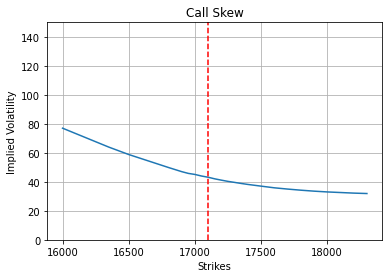

In [23]:
plt.plot(option["STRIKE"],option["Call IV"]) #, figure=(20,16)
plt.grid('True')
plt.title("Call Skew")
plt.xlabel("Strikes")
plt.ylim(bottom=0, top=150)
plt.ylabel("Implied Volatility")
plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')

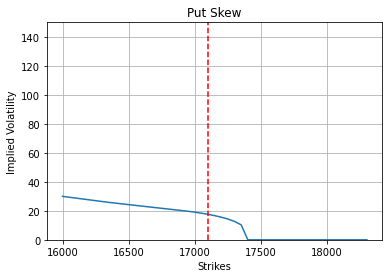

In [24]:
plt.plot(option["STRIKE"],option["Put IV"])
plt.grid('True')
plt.title("Put Skew")
plt.ylim(bottom=0, top=150)
plt.xlabel("Strikes")
plt.ylabel("Implied Volatility")
plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')